In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # type: ignore

In [33]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [ ]:
# 🔹 Section 1: Dataset Overview
df = pd.read_csv("covid_19_clean_complete.csv")
print("Dataset shape:", df.shape)
print("Date Range:", df['Date'].min(), "to", df['Date'].max())
print("Countries:", df['Country/Region'].nunique())
print(df.head())

Dataset shape: (49068, 10)
Date Range: 2020-01-22 to 2020-07-27
Countries: 187
  Province/State Country/Region       Lat       Long        Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953  2020-01-22          0   
1            NaN        Albania  41.15330  20.168300  2020-01-22          0   
2            NaN        Algeria  28.03390   1.659600  2020-01-22          0   
3            NaN        Andorra  42.50630   1.521800  2020-01-22          0   
4            NaN         Angola -11.20270  17.873900  2020-01-22          0   

   Deaths  Recovered  Active             WHO Region  
0       0          0       0  Eastern Mediterranean  
1       0          0       0                 Europe  
2       0          0       0                 Africa  
3       0          0       0                 Europe  
4       0          0       0                 Africa  


In [ ]:
# 🔹 Section 2: Data Cleaning & Preprocessing

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Replace missing Province/State values with 'N/A'
df['Province/State'] = df['Province/State'].fillna('N/A')

# Create a new 'Active' column
df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']

# Group by Date and Country/Region to aggregate case data
grouped = df.groupby(['Date', 'Country/Region'])[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum().reset_index()

# Calculate global trend by summing all countries for each date
global_trend = grouped.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum()

# Add 'Active' cases to global trend
global_trend['Active'] = global_trend['Confirmed'] - global_trend['Deaths'] - global_trend['Recovered']


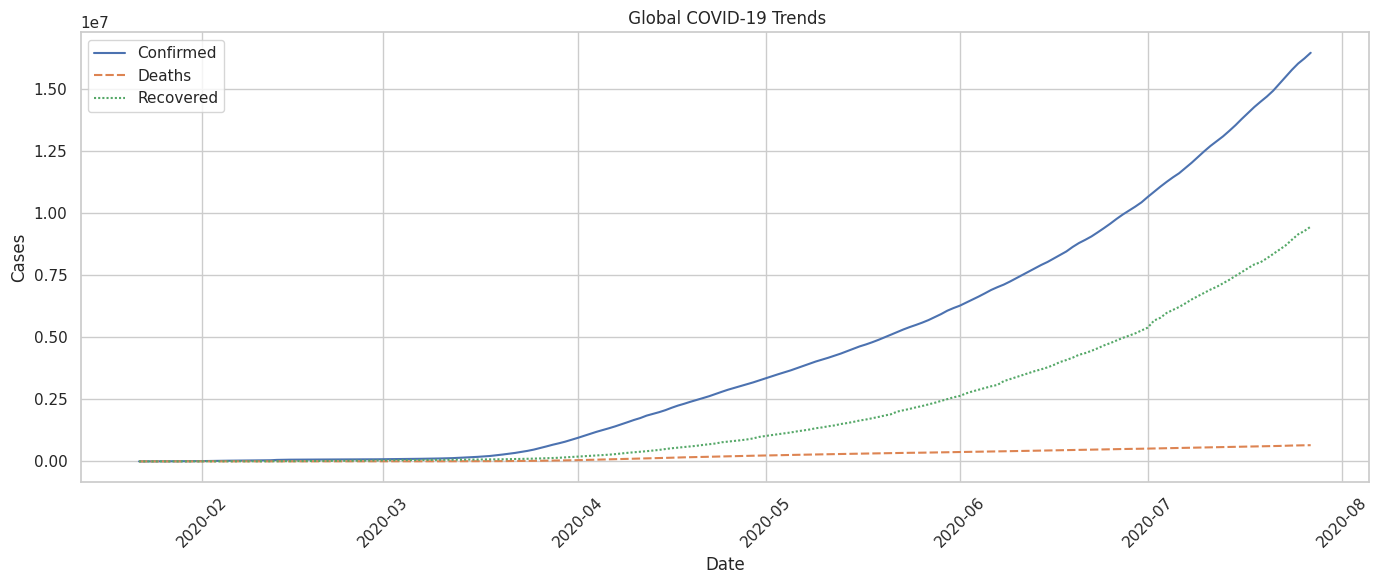

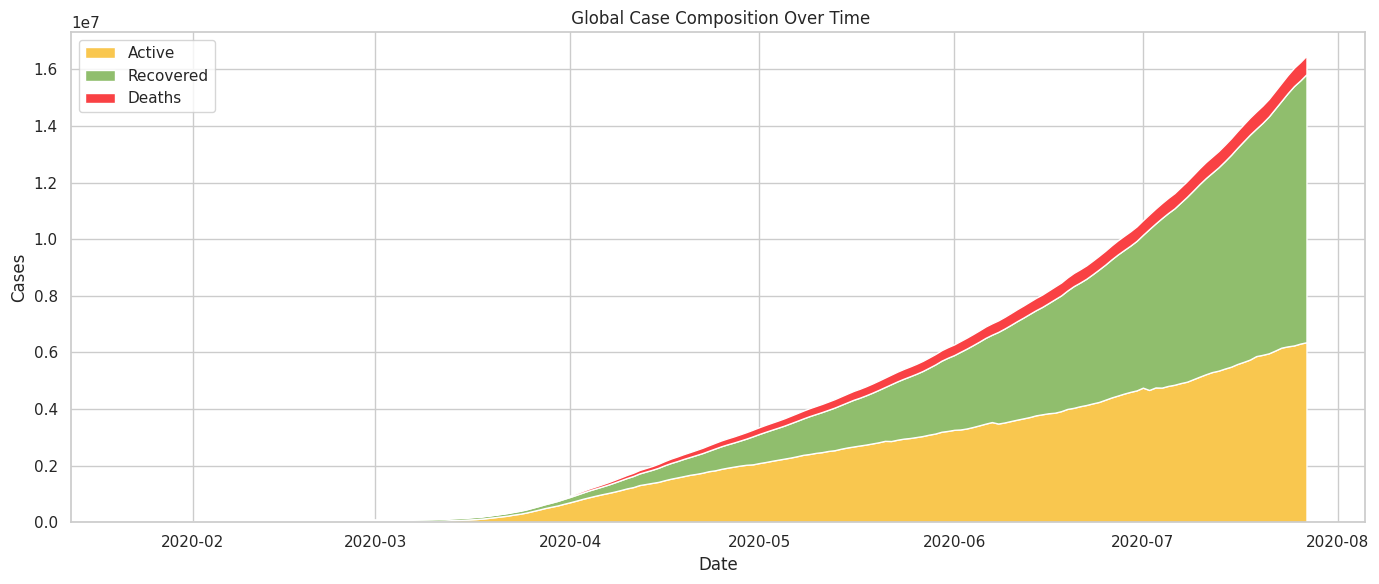

In [ ]:
# 🔹 Section 3: Global Trend Analysis
sns.lineplot(data=global_trend[['Confirmed', 'Deaths', 'Recovered']])
plt.title(" Global COVID-19 Trends")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.stackplot(global_trend.index,
              global_trend['Active'],
              global_trend['Recovered'],
              global_trend['Deaths'],
              labels=['Active', 'Recovered', 'Deaths'],
              colors=['#f9c74f', '#90be6d', '#f94144'])
plt.title(" Global Case Composition Over Time")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.tight_layout()
plt.show()

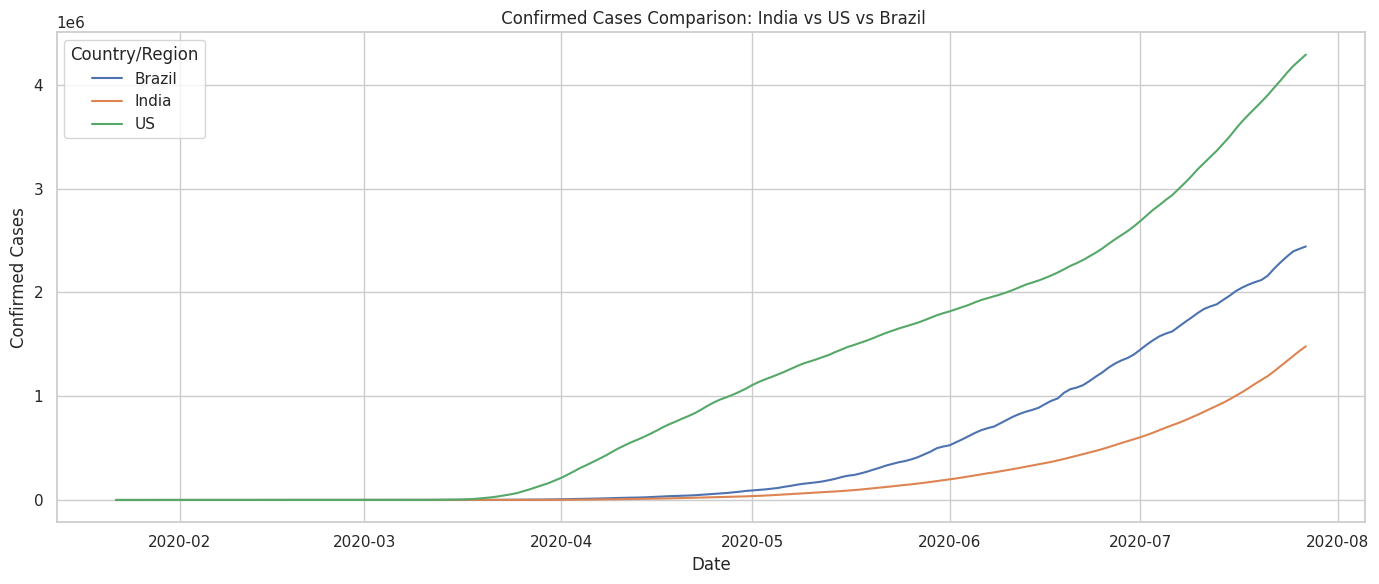

In [ ]:
# 🔹 Section 4: Country-wise Comparative Analysis
selected = ['India', 'US', 'Brazil']
country_comp = grouped[grouped['Country/Region'].isin(selected)]

sns.lineplot(data=country_comp, x='Date', y='Confirmed', hue='Country/Region')
plt.title(" Confirmed Cases Comparison: India vs US vs Brazil")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.tight_layout()
plt.show()

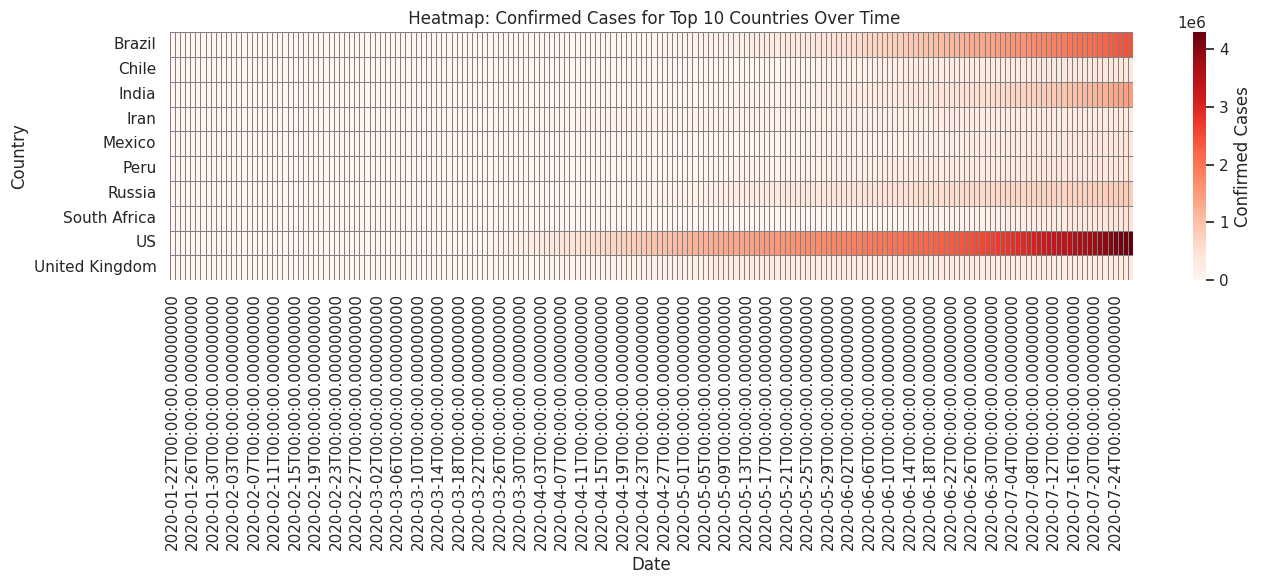

In [ ]:
# 🔹 Section 5: Heatmap of Top 10 Countries
latest_date = df['Date'].max()
latest_data = df[df['Date'] == latest_date]
top_countries = latest_data.groupby('Country/Region')['Confirmed'].sum().nlargest(10).index

heatmap_data = grouped[grouped['Country/Region'].isin(top_countries)]
heatmap_pivot = heatmap_data.pivot(index='Date', columns='Country/Region', values='Confirmed').fillna(0)

sns.heatmap(heatmap_pivot.T, cmap='Reds', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Confirmed Cases'})
plt.title(" Heatmap: Confirmed Cases for Top 10 Countries Over Time")
plt.xlabel("Date")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

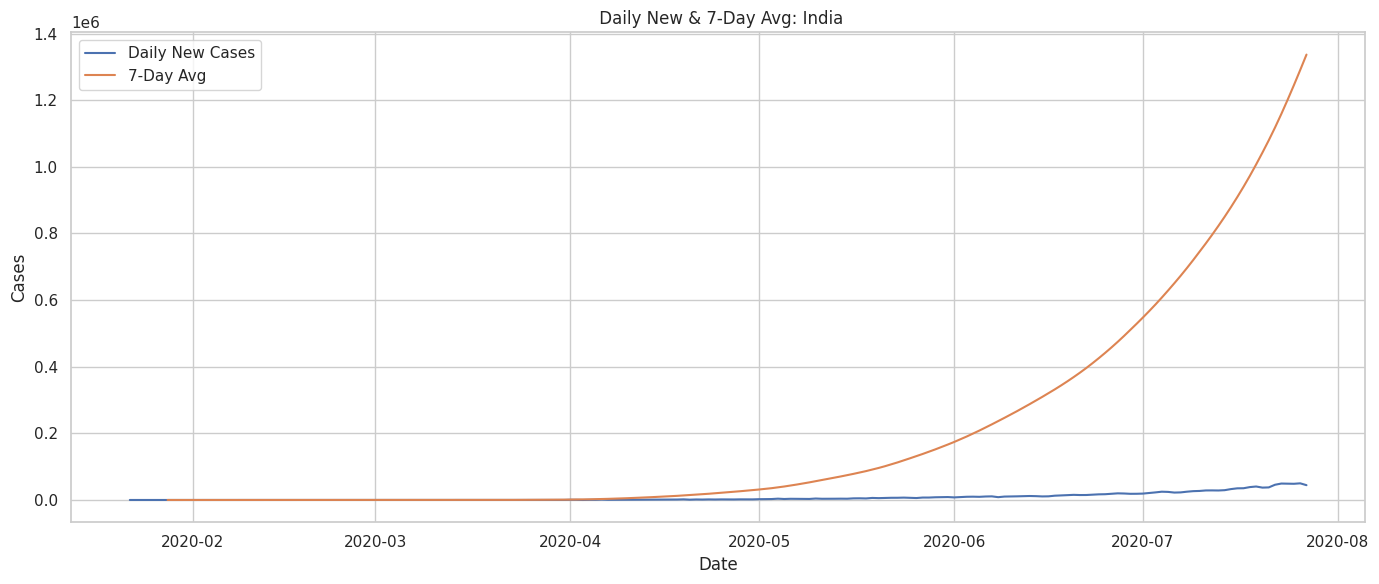

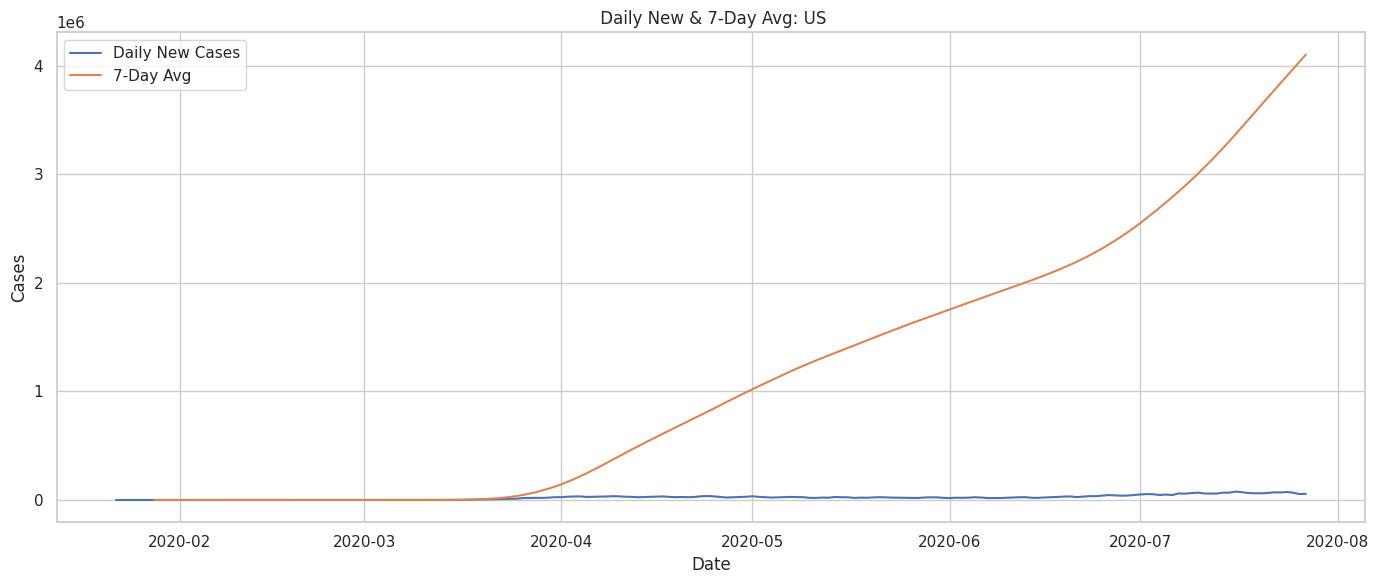

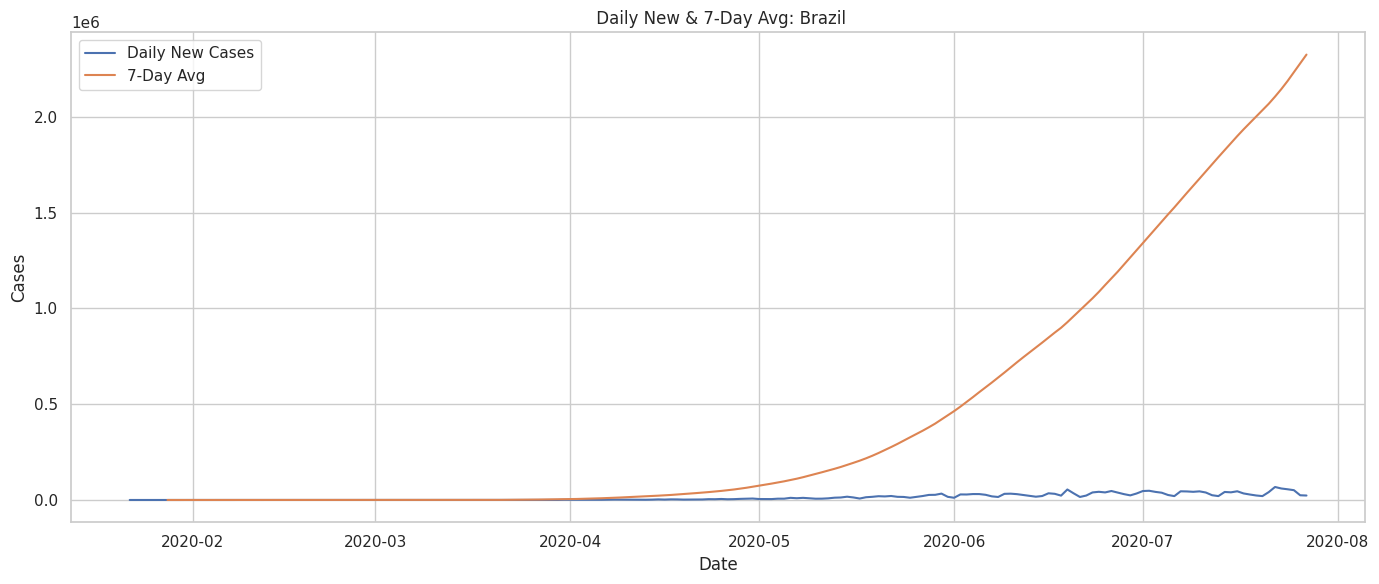

In [ ]:
# 🔹 Section 6: Daily New Cases and Rolling Average
for country in selected:
    temp = country_comp[country_comp['Country/Region'] == country]
    daily_new = temp['Confirmed'].diff().fillna(0)
    rolling_avg = temp['Confirmed'].rolling(window=7).mean()

    plt.plot(temp['Date'], daily_new, label='Daily New Cases')
    plt.plot(temp['Date'], rolling_avg, label='7-Day Avg')
    plt.title(f" Daily New & 7-Day Avg: {country}")
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.legend()
    plt.tight_layout()
    plt.show()

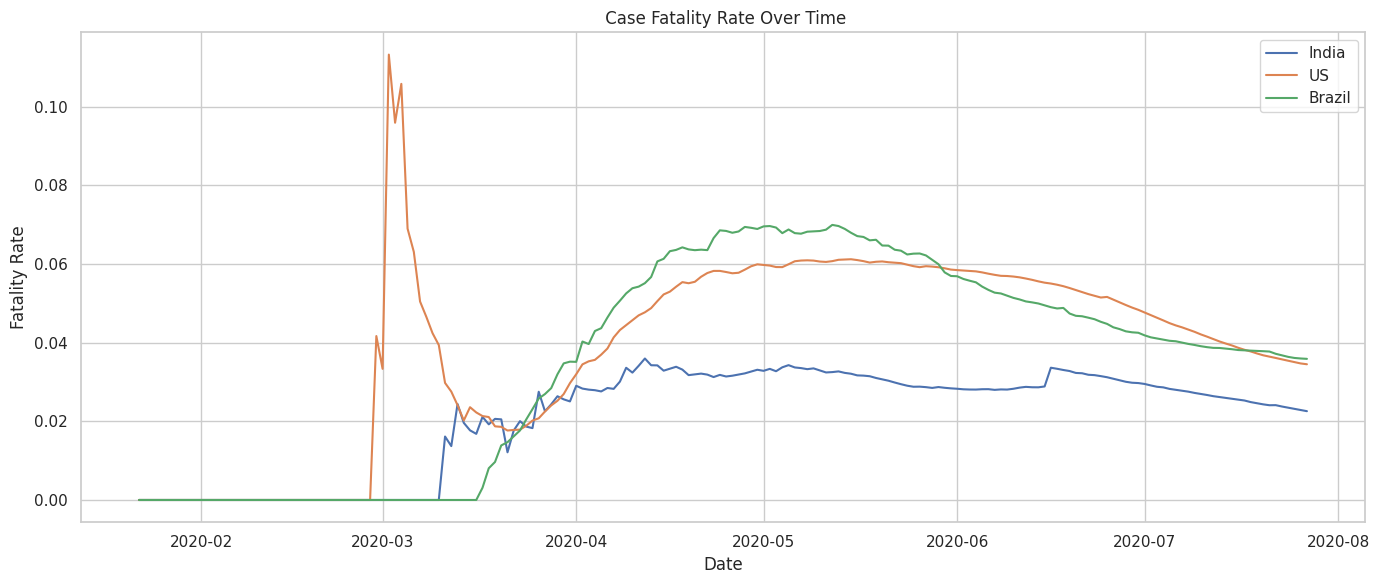

In [ ]:
# 🔹 Section 7: Case Fatality Rate (CFR) Analysis
for country in selected:
    temp = country_comp[country_comp['Country/Region'] == country]
    fatality_rate = temp['Deaths'] / temp['Confirmed'].replace(0, 1)
    plt.plot(temp['Date'], fatality_rate, label=country)

plt.title(" Case Fatality Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Fatality Rate")
plt.legend()
plt.tight_layout()
plt.show()

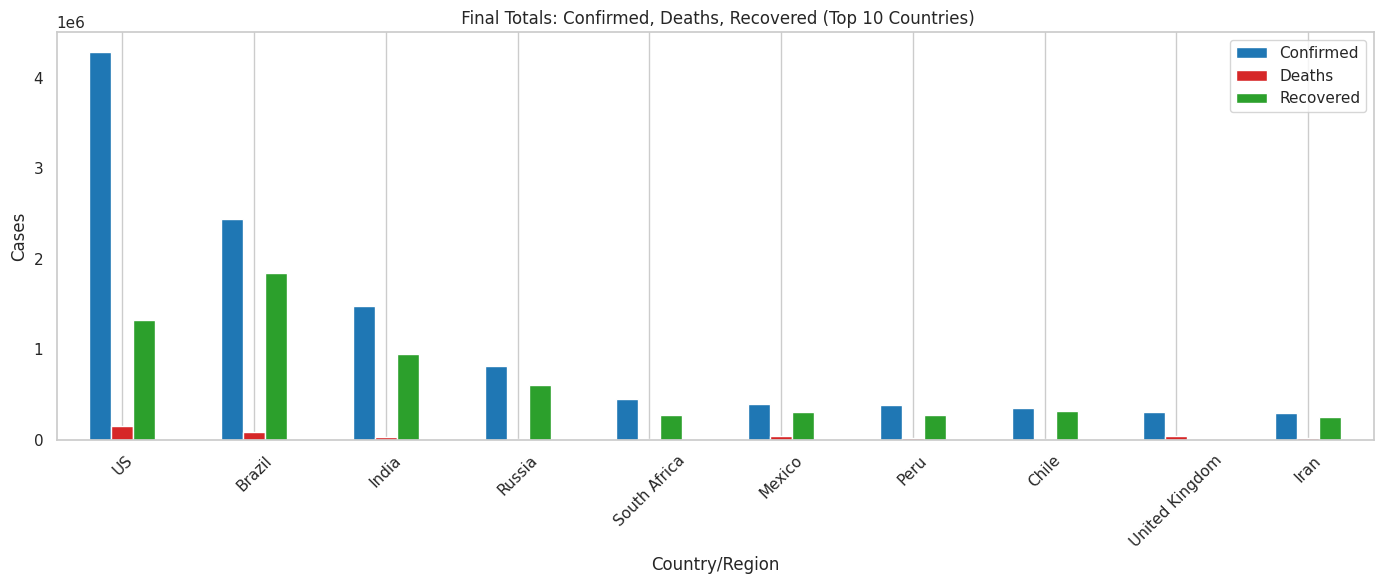

In [ ]:
# 🔹 Section 8: Bar Chart – Final Case Distribution
top_confirmed = latest_data.groupby("Country/Region")[["Confirmed", "Deaths", "Recovered"]].sum()
top_confirmed = top_confirmed.loc[top_countries]

top_confirmed.plot(kind='bar', color=['#1f77b4', '#d62728', '#2ca02c'])
plt.title(" Final Totals: Confirmed, Deaths, Recovered (Top 10 Countries)")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

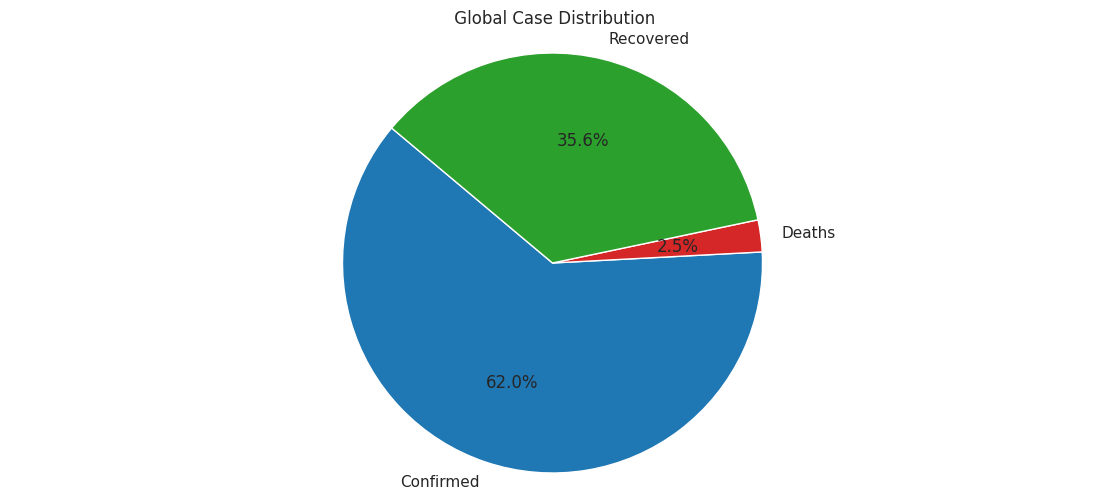

In [ ]:
# 🔹 Section 9: Pie Chart – Global Case Distribution
pie_data = latest_data[['Confirmed', 'Deaths', 'Recovered']].sum()
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140, colors=['#1f77b4', '#d62728', '#2ca02c'])
plt.title(" Global Case Distribution")
plt.axis('equal')
plt.show()

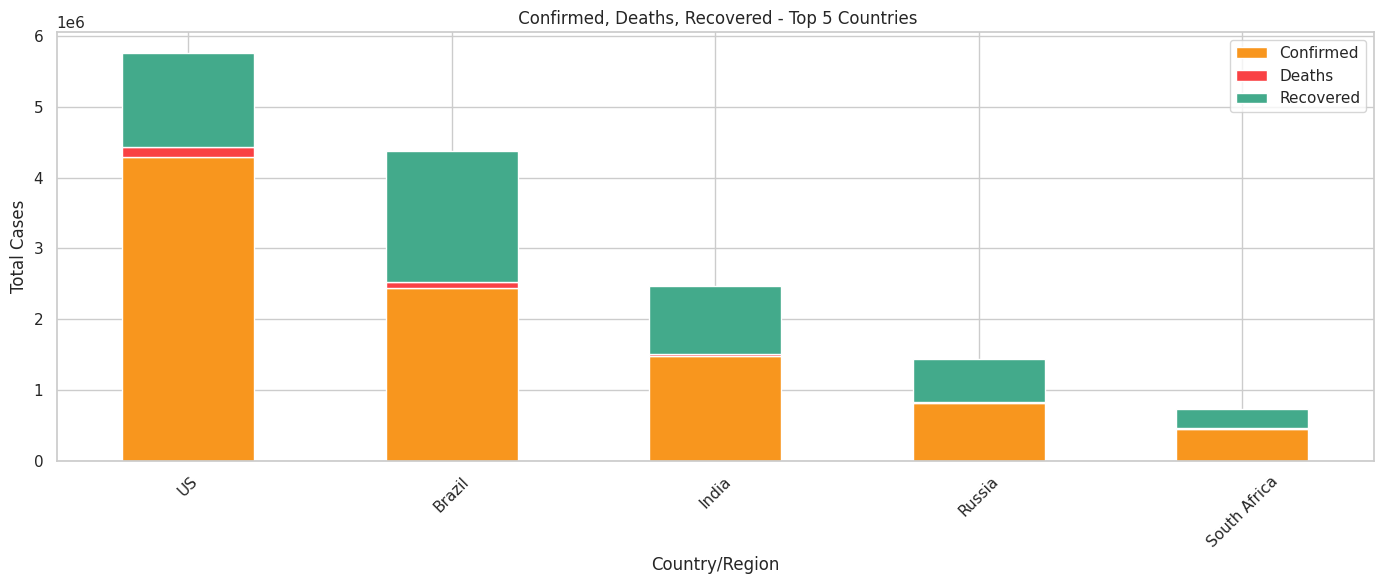

In [ ]:
# 🔹 Section 10: Stacked Bar – Top 5 Countries
top5 = latest_data.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().nlargest(5, 'Confirmed')
top5.plot(kind='bar', stacked=True, color=['#f8961e', '#f94144', '#43aa8b'])
plt.title(" Confirmed, Deaths, Recovered - Top 5 Countries")
plt.ylabel("Total Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

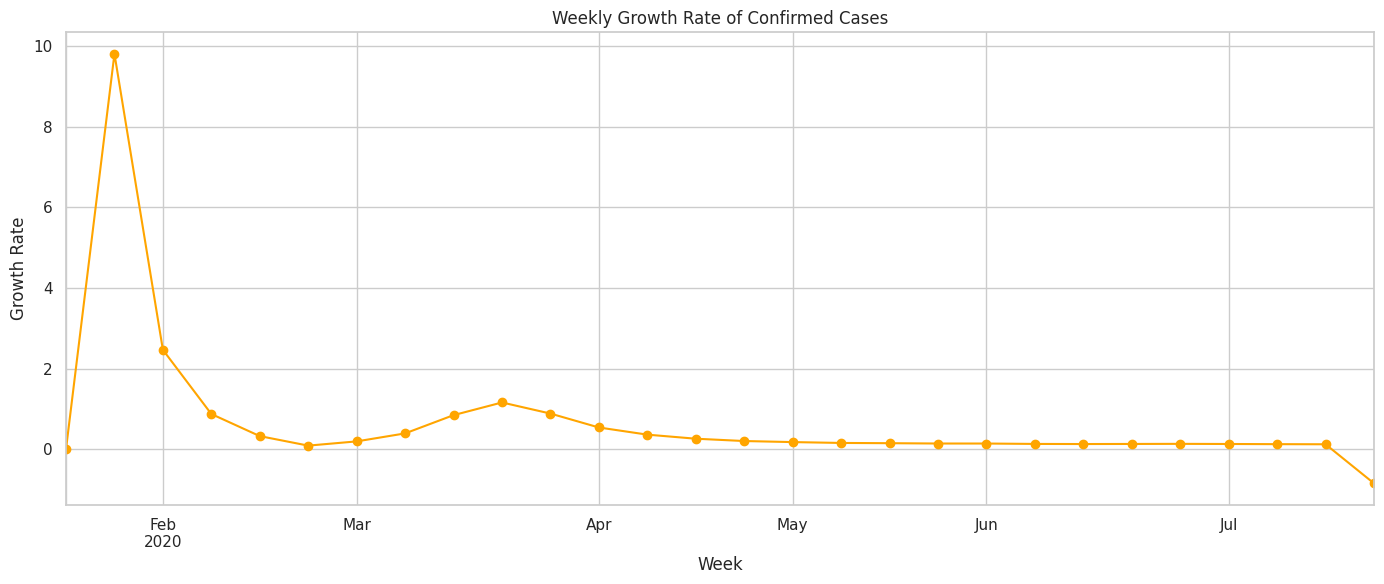

In [ ]:
# 🔹 Section 11: Growth Rate Chart – Weekly Growth Rate
df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly = df.groupby('Week')[['Confirmed']].sum()
weekly['GrowthRate'] = weekly['Confirmed'].pct_change().fillna(0)

weekly['GrowthRate'].plot(marker='o', color='orange')
plt.title("Weekly Growth Rate of Confirmed Cases")
plt.ylabel("Growth Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

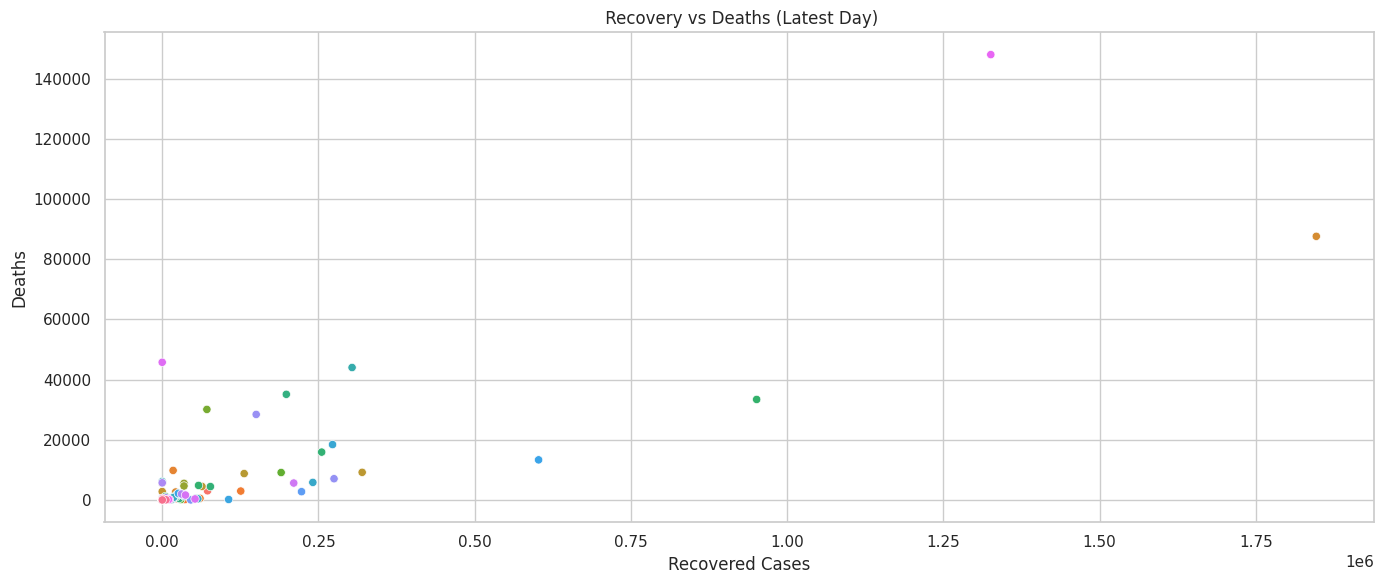

In [ ]:
# 🔹 Section 12: Recovery vs Deaths Correlation (Scatter)
sns.scatterplot(data=latest_data, x='Recovered', y='Deaths', hue='Country/Region', legend=False)
plt.title(" Recovery vs Deaths (Latest Day)")
plt.xlabel("Recovered Cases")
plt.ylabel("Deaths")
plt.grid(True)
plt.tight_layout()
plt.show()